In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(rc={"figure.figsize":(10, 6)})

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
# Null data has been handled in previous version
data_file_path = "/content/drive/MyDrive/Colab Notebooks/NLP/Classification/Nepali Sentimental Classification/not_null_sentimental_data.csv"
data = pd.read_csv(data_file_path)

In [3]:
data.sample(3)

,Unnamed: 0,Data,Label
1332,1333,ब्रिज मेकअप गर्नको लागि सबै सामान पाइन्छ,2
1586,1587,उनी पनि मेरो लागि भगवान जस्तै थिन,1
1625,1626,जानेको संस्कृत यहि हो त्यहि पनि बजाईदिए,2


In [4]:
data.drop(labels = ["Unnamed: 0"], axis = 1, inplace = True)

In [5]:
data.head()

,Data,Label
0,यो समान राम्रो रहेछ,1
1,समान राम्रो रहेछ,1
2,राम्रो रहेछ,1
3,यो घडी मलाइ साँच्चिकै सुहाउछ । म यसलाई खरीद गर...,1
4,साँच्चिकै सुहाउछ,1


In [6]:
data[data.isnull().any(axis=1)]

,Data,Label


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2186 entries, 0 to 2185
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Data    2186 non-null   object
 1   Label   2186 non-null   object
dtypes: object(2)
memory usage: 34.3+ KB


In [8]:
data["Label"] = data["Label"].astype(int)

In [9]:
data.Label.value_counts()

2    770
0    717
1    699
Name: Label, dtype: int64

# Text Preprocessing

In [10]:
!pip install nepalitokenizer
!pip install nepali-stemmer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 149 kB 4.5 MB/s 


In [11]:
from nepali_stemmer.stemmer import NepStemmer
from nepalitokenizer import NepaliTokenizer
nepstem = NepStemmer()
tokenize = NepaliTokenizer()

def text_preprocessing(text, nepali_stopwords = stopwords.words('nepali')):
  # Tokenize the reviews
  text = tokenize.tokenizer(text)
  # Remove the nepali stopwords
  text = [word for word in text if word not in nepali_stopwords]
  text = ' '.join(text)
  # Stemming the nepali words
  text = nepstem.stem(text)
  # Remove the leading and trailing spaces
  text = text.split()
  text = ' '.join(text)  
  return text

In [12]:
X = data["Data"].apply(text_preprocessing)
y = data["Label"] 

### Problem : ramro is removed during tokenization in preprocessing

In [13]:
X[:5]

0                                              समान
1                                              समान
2                                                  
3    घडी मलाइ साँच्चि कै सुहाउछ यस लाई खरीद गर्नेछु
4                                 साँच्चि कै सुहाउछ
Name: Data, dtype: object

# Train, Validation and Test Split

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 101)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = 0.5, random_state = 101)

In [15]:
print(f"Train size =  {len(X_train)}")
print(f"Validation size =  {len(X_val)}")
print(f"Test size =  {len(X_test)}")

Train size =  1748
Validation size =  219
Test size =  219


In [16]:
print(len(y_train), len(y_val), len(y_test))

1748 219 219


# One Hot Encoding

In [17]:
UNIQUE_WORD_COUNT = 3179
MAX_PAD_LENGTH = 10

In [18]:
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
tokenizer = Tokenizer(num_words = UNIQUE_WORD_COUNT)
tokenizer.fit_on_texts(X_train)

In [19]:
train_sequences = tokenizer.texts_to_sequences(X_train)
print(train_sequences[0])
train_padded = pad_sequences(train_sequences, maxlen = MAX_PAD_LENGTH, padding = 'post', truncating = 'post')
print(train_padded[0])

[2028, 7, 542, 252, 543]
[2028    7  542  252  543    0    0    0    0    0]


In [20]:
val_sequences = tokenizer.texts_to_sequences(X_val)
print(val_sequences[0])
val_padded = pad_sequences(val_sequences, maxlen = MAX_PAD_LENGTH, padding = "post", truncating = "post")
print(val_padded[0])

[2516, 66, 40]
[2516   66   40    0    0    0    0    0    0    0]


In [21]:
test_sequences = tokenizer.texts_to_sequences(X_test)
print(test_sequences[0])
test_padded = pad_sequences(test_sequences, maxlen = MAX_PAD_LENGTH, padding = "post", truncating = "post")
print(test_padded[0])

[20, 2517, 407, 794, 2518]
[  20 2517  407  794 2518    0    0    0    0    0]


In [22]:
y_train = pd.get_dummies(y_train).values
y_val = pd.get_dummies(y_val).values
y_test = pd.get_dummies(y_test).values

In [251]:
train_padded

array([[2028,    7,  542, ...,    0,    0,    0],
       [ 142,  339,  340, ...,    0,    0,    0],
       [ 545,  185,  888, ...,    0,    0,    0],
       ...,
       [ 541,  883,    0, ...,    0,    0,    0],
       [  85,    9,    3, ...,    0,    0,    0],
       [1116,  644, 1117, ...,    0,    0,    0]], dtype=int32)

In [23]:
y_train

array([[0, 0, 1],
       [0, 1, 0],
       [0, 0, 1],
       ...,
       [0, 0, 1],
       [0, 1, 0],
       [1, 0, 0]], dtype=uint8)

In [265]:
print(type(train_sequences[0]))
print(train_sequences[0])

<class 'list'>
[2028, 7, 542, 252, 543]


In [279]:
word_index = tokenizer.word_index
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode(text):
  return " ".join([reverse_word_index.get(i, "?") for i in  text])
decode( [ 803, 1588,   54, 2546, 1589,    6,   63,    0,    0,    0])


'वाह शितल पोस्ट साझा गर्न का धन्यवाद ? ? ?'

# Data Loader

In [248]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

torch.manual_seed(50)
torch.cuda.manual_seed(50)

torch.__version__

'1.13.0+cu116'

In [258]:
train_data = TensorDataset(torch.LongTensor(train_padded), torch.FloatTensor(y_train))
valid_data = TensorDataset(torch.LongTensor(val_padded), torch.FloatTensor(y_val))
test_data = TensorDataset(torch.LongTensor(test_padded), torch.FloatTensor(y_test))

BATCH_SIZE = 32
train_loader = DataLoader(train_data, batch_size = BATCH_SIZE, shuffle = True, drop_last = False)
valid_loader = DataLoader(valid_data, batch_size = BATCH_SIZE, shuffle = False, drop_last = False)
test_loader = DataLoader(test_data, batch_size = BATCH_SIZE, shuffle = False, drop_last = False)

In [ ]:
for X, y in train_loader:
  print(X)
  print(y)
  break

# Model

In [118]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [174]:
class SentimentalModelV3(nn.Module):
  def __init__(self, output_size, vocab_size, embedding_dim, hidden_dim, n_layers = 1, drop_prob = 0.3, bidirectional = False, batch_size = 32, padded_seq_len = 10):
    super().__init__()
    self.batch_size = batch_size
    self.output_size = output_size
    self.n_layers = n_layers
    self.hidden_dim = hidden_dim
    self.padded_seq_len = padded_seq_len

    self.embedding = nn.Embedding(num_embeddings = vocab_size, embedding_dim = embedding_dim)
    self.lstm = nn.LSTM(input_size = embedding_dim, hidden_size = hidden_dim, num_layers = n_layers, dropout = drop_prob, batch_first = True, bidirectional = bidirectional)

    self.dropout = nn.Dropout(0.3)

    #Linear and activation layer
    self.fc1=nn.Linear(self.hidden_dim * self.padded_seq_len, 64)
    self.fc2=nn.Linear(64, 16)
    self.fc3=nn.Linear(16,output_size)
    self.Relu = nn.ReLU()

  def forward(self, one_hot, hn, cn):
    embed = self.embedding(one_hot)
    lstm_out, hidden = self.lstm(embed)

    #stack up the lstm output
    lstm_out = lstm_out.reshape(shape = (lstm_out.shape[0], lstm_out.shape[1] * lstm_out.shape[2]))
    # dropout and fully connected layers
    out = self.dropout(lstm_out)
    out = self.Relu(out)
    out = self.Relu(self.fc1(out))
    out = self.Relu(self.fc2(out))
    out = self.fc3(out)

    return out

  def initCellState(self):
    h =  torch.zeros(self.n_layers , self.batch_size , self.hidden_dim).to(device)
    c =  torch.zeros(self.n_layers , self.batch_size , self.hidden_dim).to(device)
    return h, c

In [175]:
model_v3 = SentimentalModelV3(output_size = 3, 
                              vocab_size = UNIQUE_WORD_COUNT, 
                              embedding_dim = 64, 
                              hidden_dim = 32, 
                              n_layers = 5, 
                              drop_prob = 0.3, 
                              padded_seq_len = MAX_PAD_LENGTH).to(device)

In [176]:
model_v3
hn, cn = model_v3.initCellState()

In [177]:
hn.shape

torch.Size([5, 32, 32])

In [178]:
cn.shape

torch.Size([5, 32, 32])

In [179]:
X.shape

torch.Size([32, 10])

In [180]:
X, y = next(iter(train_loader))
model_v3.eval()
with torch.inference_mode():
  pred = model_v3(X, hn, cn)

pred.shape

torch.Size([32, 3])

In [181]:
embedding = nn.Embedding(num_embeddings = UNIQUE_WORD_COUNT, embedding_dim = 64)
embed = embedding(X)
print(f"From Embedding layer output: {embed.shape}")

lstm = nn.LSTM(input_size = 64, hidden_size = 32, num_layers = 2, dropout = 0.3, batch_first = True, bidirectional = False)
lstm_out, (hn, cn) = lstm(embed)
print(f"lstm output shape : {lstm_out.shape}")
lstm_out = lstm_out.reshape(shape = (32, 32 * 10))
print(lstm_out.shape)

fc1=nn.Linear(in_features = 320, out_features = 64)
fc1(lstm_out).shape

From Embedding layer output: torch.Size([32, 10, 64])
lstm output shape : torch.Size([32, 10, 32])
torch.Size([32, 320])


torch.Size([32, 64])

# Training, Validation and Testing loop

In [197]:
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer):
  hn, cn = model.initCellState()
  # put the model in train mode
  model.train()

  # setup the train loss and train accuracy values
  train_loss, train_acc  = 0, 0

  # Loop through the data loader data batches
  for batch, (X, y) in enumerate(dataloader):
    # send data to target device
    X, y = X.to(device), y.to(device)
    # Forward pass
    y_pred = model(X, hn, cn)

    # calculate and accumulate loss
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    # detach the cell state as it is not the parameter to be optimizerd
    hn = hn.detach()
    cn = cn.detach()

    # optimzer zero grad
    optimizer.zero_grad()

    # Loss backward
    loss.backward()

    # optimizer step
    optimizer.step()

    # calculate the accumulate accuracy metric across all batches
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim = 1), dim = 1)
    y_true_class = torch.argmax(torch.softmax(y, dim = 1), dim = 1)
    train_acc += (y_pred_class == y_true_class).sum().item() / len(y_pred)
  
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)

  return train_loss, train_acc


In [198]:
def val_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module):
  hn, cn = model.initCellState()
  model.eval()
  val_loss, val_acc = 0, 0
  with torch.inference_mode():
    for batch, (X, y) in enumerate(dataloader):
      X, y = X.to(device), y.to(device)

      # forward pass
      val_pred_logits = model(X, hn, cn)

      # calculate and accumulate loss
      loss = loss_fn(val_pred_logits, y)
      val_loss += loss.item()

      # calculate and accumulate accuracy
      y_pred_class = torch.argmax(torch.softmax(val_pred_logits, dim = 1), dim = 1)
      y_true_class = torch.argmax(torch.softmax(y, dim = 1), dim = 1)
      val_acc += (y_pred_class == y_true_class).sum().item() / len(val_pred_logits)

  val_loss = val_loss / len(dataloader)
  val_acc = val_acc / len(dataloader)
  return val_loss, val_acc


In [199]:
from tqdm.auto import tqdm

def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer, 
          loss_fn: torch.nn.Module, 
          epochs: int = 5):
  results = {
      "train_loss" : [],
      "train_acc" : [], 
      "val_loss" : [], 
      "val_acc" : []
  }

  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model = model, 
                                       dataloader = train_dataloader, 
                                       loss_fn = loss_fn, 
                                       optimizer = optimizer)
    
    val_loss, val_acc = val_step(model = model, 
                                    dataloader = test_dataloader, 
                                    loss_fn = loss_fn)
    
    print(
        f"Epoch: {epoch+1} | "
        f"train_loss: {train_loss:.4f} | "
        f"train_acc: {train_acc:.4f} | "
        f"val_loss: {val_loss:.4f} | "
        f"val_acc: {val_acc:.4f}"
    )

    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["val_loss"].append(val_loss)
    results["val_acc"].append(val_acc)
  return results

In [200]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

NUM_EPOCHS = 5

model_v3 = SentimentalModelV3(output_size = 3, 
                              vocab_size = UNIQUE_WORD_COUNT, 
                              embedding_dim = 128, 
                              hidden_dim = 64, 
                              n_layers = 5, 
                              drop_prob = 0.3, 
                              padded_seq_len = 10, 
                              bidirectional = False).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_v3.parameters(), lr=0.001)

In [204]:
model_v3_results = train(model = model_v3, train_dataloader = train_loader, test_dataloader = test_loader, optimizer = optimizer, loss_fn = loss_fn, epochs = 20)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.1656 | train_acc: 0.9411 | val_loss: 1.7982 | val_acc: 0.6098
Epoch: 2 | train_loss: 0.1570 | train_acc: 0.9426 | val_loss: 1.7549 | val_acc: 0.6276
Epoch: 3 | train_loss: 0.1447 | train_acc: 0.9411 | val_loss: 1.7965 | val_acc: 0.6106
Epoch: 4 | train_loss: 0.1388 | train_acc: 0.9472 | val_loss: 1.7142 | val_acc: 0.6151
Epoch: 5 | train_loss: 0.1322 | train_acc: 0.9506 | val_loss: 2.0345 | val_acc: 0.6151
Epoch: 6 | train_loss: 0.1246 | train_acc: 0.9511 | val_loss: 1.7794 | val_acc: 0.5972
Epoch: 7 | train_loss: 0.1231 | train_acc: 0.9548 | val_loss: 1.7962 | val_acc: 0.6195
Epoch: 8 | train_loss: 0.1103 | train_acc: 0.9557 | val_loss: 2.1709 | val_acc: 0.6195
Epoch: 9 | train_loss: 0.1081 | train_acc: 0.9534 | val_loss: 2.1936 | val_acc: 0.5980
Epoch: 10 | train_loss: 0.0864 | train_acc: 0.9588 | val_loss: 2.3488 | val_acc: 0.5847
Epoch: 11 | train_loss: 0.0808 | train_acc: 0.9610 | val_loss: 2.5265 | val_acc: 0.5928
Epoch: 12 | train_loss: 0.0872 | train_ac

In [304]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 512 kB 5.1 MB/s 


# Test Data Evaluation

In [305]:
def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module):
  hn, cn = model.initCellState()
  model.eval()
  test_loss, test_acc = 0, 0

  test_pred, test_true = [], []
  
  with torch.inference_mode():
    for batch, (X, y) in enumerate(dataloader):
      X, y = X.to(device), y.to(device)

      # forward pass
      val_pred_logits = model(X, hn, cn)

      # calculate and accumulate loss
      loss = loss_fn(val_pred_logits, y)
      test_loss += loss.item()

      # calculate and accumulate accuracy
      y_pred_class = torch.argmax(torch.softmax(val_pred_logits, dim = 1), dim = 1)
      y_true_class = torch.argmax(torch.softmax(y, dim = 1), dim = 1)
      test_acc += (y_pred_class == y_true_class).sum().item() / len(val_pred_logits)
      
      test_pred.append(y_pred_class.cpu())
      test_true.append(y_true_class.cpu())

  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc, torch.cat(test_pred), torch.cat(test_true)

In [306]:
test_loss, test_acc, test_pred, test_true = test_step(model_v3, test_loader, loss_fn)
test_loss, test_acc

(2.5134925161089217, 0.5830026455026455)

In [308]:
test_pred

tensor([0, 2, 0, 2, 0, 1, 1, 0, 2, 2, 0, 1, 2, 1, 1, 2, 1, 1, 0, 2, 0, 1, 2, 1,
        2, 1, 2, 0, 0, 0, 1, 0, 2, 0, 1, 1, 2, 1, 2, 0, 0, 2, 1, 1, 1, 2, 2, 0,
        0, 0, 2, 2, 0, 0, 1, 1, 2, 1, 2, 1, 0, 0, 2, 1, 2, 2, 2, 0, 1, 1, 0, 1,
        0, 1, 0, 0, 0, 2, 1, 0, 2, 2, 1, 2, 1, 1, 2, 1, 1, 1, 1, 0, 2, 0, 0, 2,
        2, 0, 1, 2, 1, 1, 0, 1, 0, 2, 2, 2, 0, 2, 2, 1, 1, 1, 0, 2, 0, 2, 0, 2,
        2, 1, 2, 0, 2, 0, 2, 1, 1, 1, 2, 2, 2, 2, 0, 2, 0, 1, 1, 2, 2, 1, 0, 1,
        0, 1, 2, 1, 0, 2, 1, 2, 1, 0, 1, 2, 0, 2, 1, 1, 1, 0, 2, 0, 0, 2, 1, 0,
        2, 0, 2, 0, 2, 2, 0, 1, 2, 2, 0, 1, 2, 1, 1, 1, 2, 2, 2, 1, 2, 1, 2, 0,
        1, 2, 2, 0, 0, 2, 2, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 2, 2, 0, 1, 1, 1,
        2, 0, 0])

In [309]:
test_true

tensor([0, 2, 2, 0, 2, 0, 2, 0, 0, 2, 2, 2, 0, 1, 1, 2, 1, 1, 0, 2, 0, 1, 0, 2,
        2, 1, 0, 0, 0, 0, 1, 0, 2, 0, 0, 1, 0, 1, 2, 1, 2, 2, 1, 1, 1, 2, 2, 2,
        0, 0, 0, 0, 0, 2, 1, 2, 2, 0, 2, 0, 2, 2, 2, 1, 1, 0, 2, 1, 2, 0, 0, 2,
        2, 2, 1, 0, 0, 2, 1, 0, 0, 2, 1, 0, 1, 0, 2, 2, 1, 2, 1, 0, 2, 1, 0, 0,
        0, 0, 2, 0, 1, 2, 0, 1, 0, 0, 2, 2, 2, 1, 0, 2, 1, 1, 0, 0, 1, 2, 0, 2,
        2, 1, 2, 0, 0, 0, 2, 1, 2, 1, 2, 2, 2, 2, 0, 0, 2, 1, 1, 2, 2, 0, 0, 1,
        1, 1, 1, 1, 0, 0, 2, 2, 1, 0, 1, 0, 2, 0, 1, 1, 1, 1, 2, 0, 0, 0, 1, 0,
        2, 0, 0, 0, 0, 2, 2, 1, 0, 2, 2, 1, 1, 0, 1, 2, 0, 0, 1, 1, 2, 1, 1, 0,
        1, 2, 2, 2, 1, 2, 2, 1, 0, 2, 1, 1, 2, 0, 2, 2, 0, 2, 2, 1, 0, 1, 1, 2,
        1, 2, 2])

In [311]:
from sklearn.metrics import confusion_matrix, classification_report

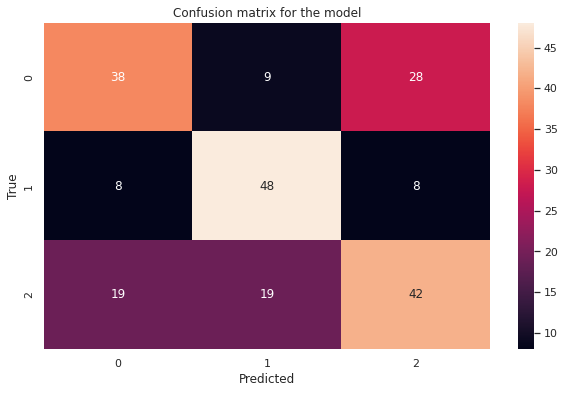

In [313]:
test_pred = list(test_pred)
test_true = list(test_true)
cm = confusion_matrix(y_true = test_true, y_pred = test_pred)
cm_heatmap = sns.heatmap(cm, annot = True)
cm_heatmap.set(xlabel = "Predicted", ylabel = "True", title = "Confusion matrix for the model")
plt.show()

In [314]:
print(classification_report(y_true = test_true, y_pred = test_pred, target_names = ['Negative', 'Positive', 'Neutral']))

              precision    recall  f1-score   support

    Negative       0.58      0.51      0.54        75
    Positive       0.63      0.75      0.69        64
     Neutral       0.54      0.53      0.53        80

    accuracy                           0.58       219
   macro avg       0.58      0.59      0.59       219
weighted avg       0.58      0.58      0.58       219



# Test your own data

In [205]:
!pip install nepali-unicode-converter

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [206]:
from nepali_unicode_converter.convert import Converter

converter = Converter()

आहा ! कति राम्रो। जे होस् गजब को रहेxअ


In [292]:
def testOwnString(own_string, model, padded_length = 10):
  # preprocessing of own_string to padded string
  own_string = text_preprocessing(own_string)
  own_string_list = [own_string]
  own_string_series = pd.Series(own_string_list)
  own_string_sequences = tokenizer.texts_to_sequences(own_string_series)
  own_string_padded = pad_sequences(own_string_sequences, maxlen = padded_length, padding = "post", truncating = "post")
  print(own_string_padded)

  # conversion to pytorch tensor
  X = torch.tensor(own_string_padded)
  hn, cn = model_v3.initCellState()
  model_v3.eval()
  with torch.inference_mode():
    pred = model_v3(X, hn, cn)
    pred_probabilities = torch.softmax(pred, dim = 1)
    pred_label = torch.argmax(pred_probabilities, dim = 1)
  return pred_probabilities, pred_label.item()

In [297]:
mystring = 'aahaa ! kati raamro. je hos gajaba ko rahexa'
own_string = converter.convert(mystring)
print(own_string)
testOwnString(own_string, model = model_v3)

आहा ! कति राम्रो। जे होस् गजब को रहेxअ
[[ 539 2777    0    0    0    0    0    0    0    0]]


(tensor([[3.5098e-05, 9.9993e-01, 3.1061e-05]]), 1)

In [294]:
own_string = "देश मा चुनाव मा भोट हाल्ने नैसर्गिक अधिकार बन्चित गरिए"
testOwnString(own_string, model = model_v3)

[[  7 230 435 168 674 436 437 275   0   0]]


(tensor([[9.9768e-01, 3.1832e-05, 2.2834e-03]]), 0)

In [295]:
own_string = "वाह जे होस् गजब को रहेxअ"
testOwnString(own_string, model = model_v3)

[[ 803  539 2777    0    0    0    0    0    0    0]]


(tensor([[3.9784e-06, 9.9999e-01, 3.4854e-06]]), 1)

In [303]:
mystring = 'mero naama niraajana ho'
own_string = converter.convert(mystring)
print(own_string)
testOwnString(own_string, model = model_v3, padded_length = MAX_PAD_LENGTH)

मेरो नाम निराजन हो
[[79  0  0  0  0  0  0  0  0  0]]


(tensor([[0.2794, 0.4425, 0.2782]]), 1)